<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Wavelet Analysis with Pyleoclim

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751)

## Preamble
Wavelet analysis is one of the most misused tools in climate timeseries analysis, partially due to the popularity of [this webpage](https://atoc.colorado.edu/research/wavelets/), which used to feature an interactive  plotter. Wavelets are a very broad topic in applied mathematics, which we won't attempt to summarize here. In the paleoclimate context, the term nearly always refers to the Continuous Wavelet Transform, and 99% of the time this uses the Morlet wavelet, which is a generalization of Fourier bases to endow them with localization in time and scale. Accordingly, this demo focuses on how to obtain wavelet spectra from the iconic EPICA Dome C record by [Jouzel et al. (2007)](https://doi.org/10.1126/science.1141038), and how to establish its coherency with a record of atmospheric $CO_2$. 

### Goals

- How to perform wavelet analysis and wavelet coherence in `Pyleoclim`
- Wavelet and coherence analysis for evenly- vs unevenly-spaced data
- Learning about the [Scalogram](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#scalogram-pyleoclim-scalogram) and [Coherence](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#coherence-pyleoclim-coherence) classes
- How to establish the significance of scalogram or coherence
- How to interpret the results of wavelet and wavelet coherence analyses 

**Reading Time: 20 min**

### Keywords
Wavelet Analysis, Wavelet Transform Coherency, Visualization 

### Pre-requisites
Some timeseries analysis, ideally 

### Relevant Packages
pyleoclim, pandas, matplotlib, numpy

## Data description

- ice phase deuterium data ($\delta D$) from [Jouzel et al. (2007)](https://doi.org/10.1126/science.1141038). $\delta D$  is a proxy for the temperature of snow formation above the site, taken to be representative of Antartic temperature over such timescales.
 
-  gas phase $CO_2$ measurements from [Luthi et al (2008)](https://www.nature.com/articles/nature06949), corrected by [Bereiter et al. (2015)](http://onlinelibrary.wiley.com/doi/10.1002/2014GL061957/abstract).

## Demonstration

Let us first load necessary packages:

In [1]:
%load_ext watermark

import matplotlib.pyplot as plt
import pandas as pd
import pyleoclim as pyleo
import numpy as np

/Users/julieneg/opt/miniconda3/envs/pyleo/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


### Loading and visualizing $\delta D$ series

We use `pandas` to load the data:

In [2]:
dDdf = pd.read_csv('../data/edc3deuttemp2007.csv')
dDdf.head()

,Age,Deuterium,Temperature
0,38.37379,-390.9,0.88
1,46.81203,-385.1,1.84
2,55.05624,-377.8,3.04
3,64.41511,-394.1,0.35
4,73.15077,-398.7,-0.42


Put the data into a [Series object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#series-pyleoclim-series) and plot it:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>)

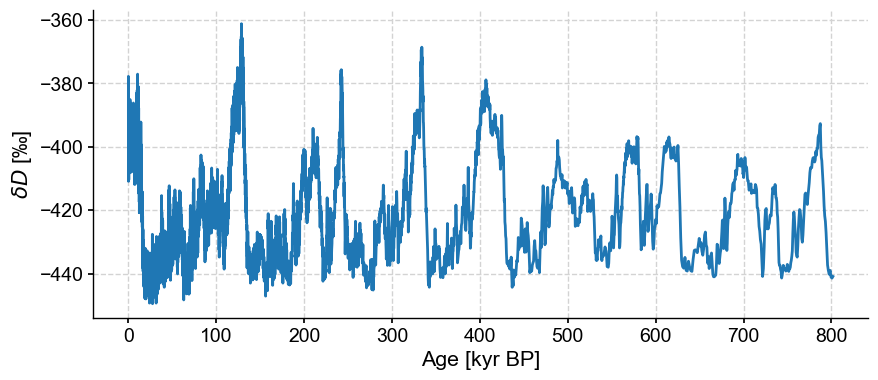

In [20]:
dDts = pyleo.Series(time=dDdf['Age']/1000,
                    value= dDdf['Deuterium'],
                    time_name='Age',time_unit='kyr BP',
                    value_name = r'$\delta D$',value_unit=u'\u2030',
                    label=r'EPICA Dome C $\delta D$',
                    verbose=False)
dDts.plot()

Notice how we put in quite a bit of metadata (information about the data) when we created the Series object, and that this information is now being used by the code to properly label axes for you. Structuring and labeling your data is a little more work upfront but it pays big dividends down the line. Let's see that now.

First, take a look at the distribution of time increments: 

Text(0.5, 1.0, 'Distribution of age increments')

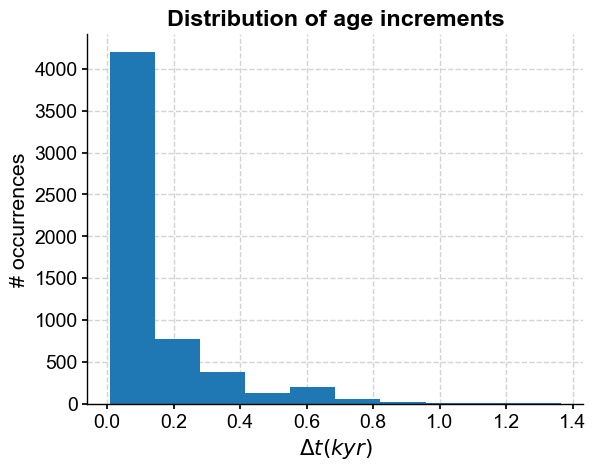

In [4]:
fig, ax = plt.subplots()
plt.hist(np.diff(dDts.time))
plt.xlabel(r'$\Delta t (kyr)$')
plt.ylabel('# occurrences')
plt.title('Distribution of age increments',weight='bold')

The data are not evenly spaced, which is a challenge because most timeseries analysis methods (particularly Fourier and wavelet analysis) make the implicit assumption that data are evenly spaced, so applying those tools to unevenly-spaced data will result in methods not behaving as they are supposed to. `pyleoclim` is one of very few packages to enable the Weighted-Wavelet Z transform of [Foster (1996)](https://adsabs.harvard.edu/full/1996AJ....112.1709F), which is designed for unevenly-spaced data. Unfortunately, and despite heroic feats of numerical optimization by its writer Feng Zhu, it can be very slow to run on large datasets, particularly when assessing significance with thousands of Monte Carlo simulations. We therefore interpolate the data at 500y resolution to enable the much faster CWT algorithm of [Torrence & Compo (1998)](https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2) to run. We also standardize because the  original data range is rather large, which could cause numerical issues.

In [5]:
dD05 = dDts.interp(step=0.5).standardize() 

### Wavelet Analysis

Lastly, we play with wavelet analysis, which may be used to "unfold" a spectrum and look at its evolution over time. There are several ways to access that functionality in Pyleoclim, but here we use `summary_plot`, which stacks together the timeseries itself, its scalogram (a plot of the magnitude of the wavelet power), and the power spectral density (PSD) obtained from summing the wavelet coefficients over time. 

In [6]:
scal = dD05.wavelet()

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'EPICA Dome C $\\delta D$ scalogram (CWT)'}, xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>)

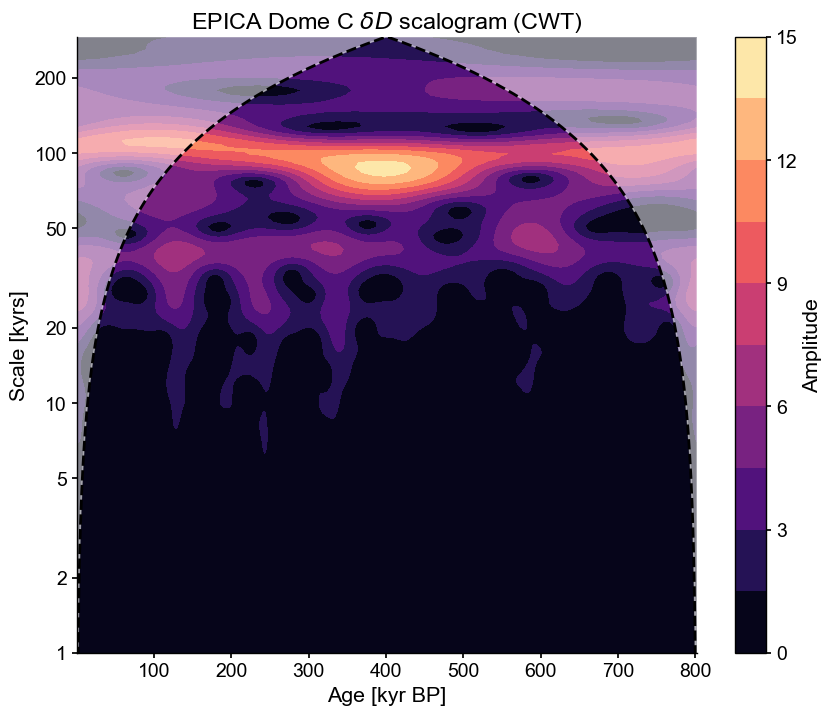

In [7]:
scal.plot()

The scalogram reveals how spectral power (technically, wavelet power) changes over time. But which aspects of this are significant? There are two ways to test this in `pyleoclim`, both using an AR(1) benchmark. The first uses a parametric, asymptotic form of the theoretical spectrum of an AR(1) process:

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'EPICA Dome C $\\delta D$ scalogram (CWT) with 95% threshold'}, xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>)

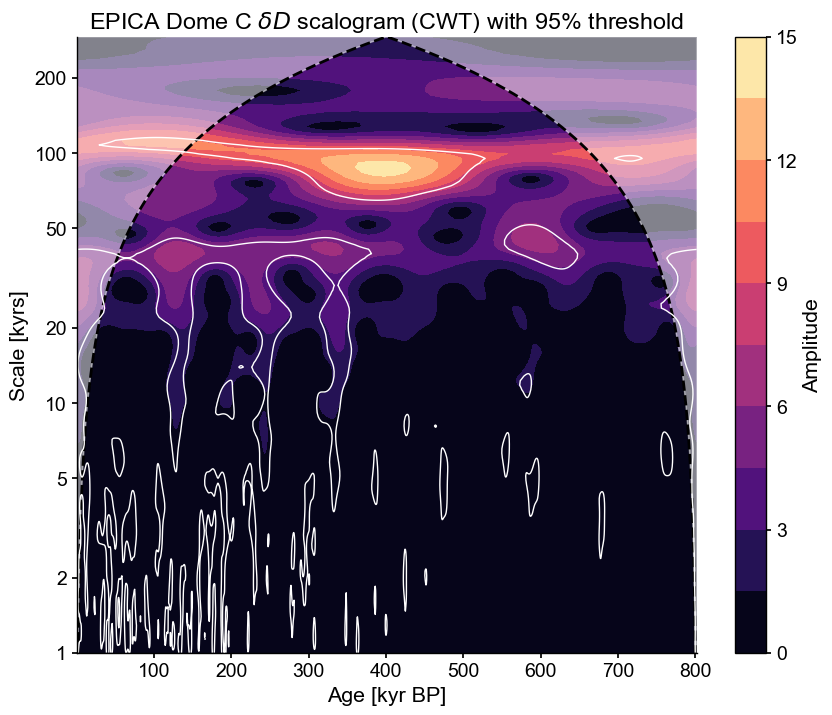

In [8]:
scal_sig = scal.signif_test(method='ar1asym')
scal_sig.plot()

The white lines delineate regions of the scalogram that are significant against an AR(1) benchmark, thus encircling "islands" of notable power. We see that the 100kyr periodicity is particularly pronounced around 300-600 kyr BP, while the 40 and 20kyr periodicities are more pronounced in the later portions (since 400 ky BP). This may be because of the compaction of the ice at depth, which you wouldn't know from analyzing just this dataset. Paleoclimate timeseries must always be interpreted with those possible artifacts in mind. There are a lot of significant islands at short (<5ky) scales as well, but it is unclear whether this is reflective of large-scale climate variability.

Now, notice that we specified the method 'ar1asym' for the asssessment of significance; this tells the code to use an asymptotic approximation to the distribution of the AR(1) benchmarks, making it lightning-fast. We could also have used direct simulation (the default method, because it applies to other wavelet methods like `wwz`), and indeed this would yield a very similar result: 

Performing wavelet analysis on individual series: 100%|██████████| 1000/1000 [00:37<00:00, 26.59it/s]


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'EPICA Dome C $\\delta D$ scalogram (CWT) with 95% threshold'}, xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>)

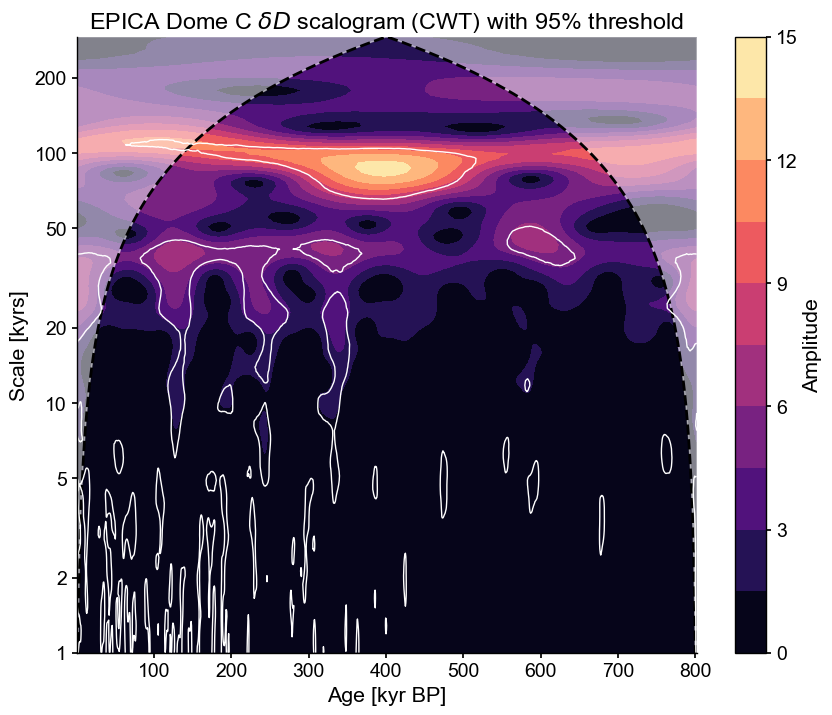

In [9]:
scal_sig2 = scal.signif_test(method='ar1sim', number = 1000)
scal_sig2.plot()

### Temperature vs $CO_2$

Now let us load the $CO_2$ composite from this and other neighboring sites around Antarctica:

In [10]:
url = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt'
co2df = pd.read_csv(url,skiprows=137,sep='\t')
co2df.head()

,age_gas_calBP,co2_ppm,co2_1s_ppm
0,-51.03,368.02,0.06
1,-48.00,361.78,0.37
2,-46.28,359.65,0.10
3,-44.41,357.11,0.16
4,-43.08,353.95,0.04


Note that `Pandas` does not always require the file to be on your local computer to load the data. In this case, we passed a simple URL.

In [11]:
co2ts = pyleo.Series(time=co2df['age_gas_calBP']/1000,value= co2df['co2_ppm'],time_name='Age',time_unit='kyr BP',value_name = r'$CO_2$',value_unit='ppm',label='EPICA Dome C CO2')

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='$CO_2$ [ppm]'>)

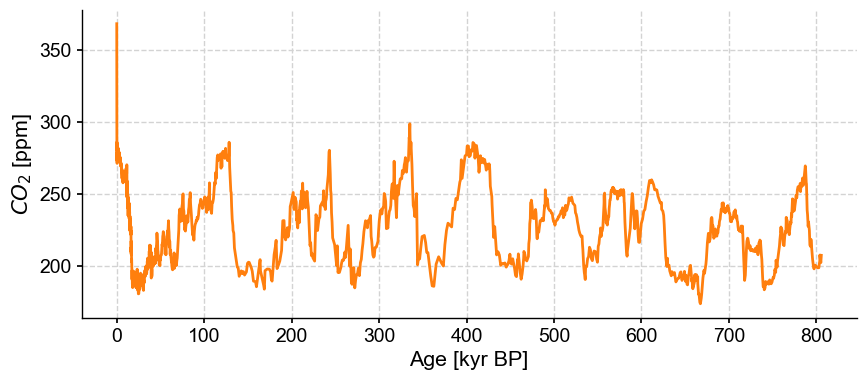

In [12]:
co2ts.plot(color='C1')

We see very similar Ice Ages as in the deuterium data and of course a precipitous rise since the Industrial Revolution.  To plot the two series side by side, we can put them into a `MultipleSeries` object and use the default plot function:

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

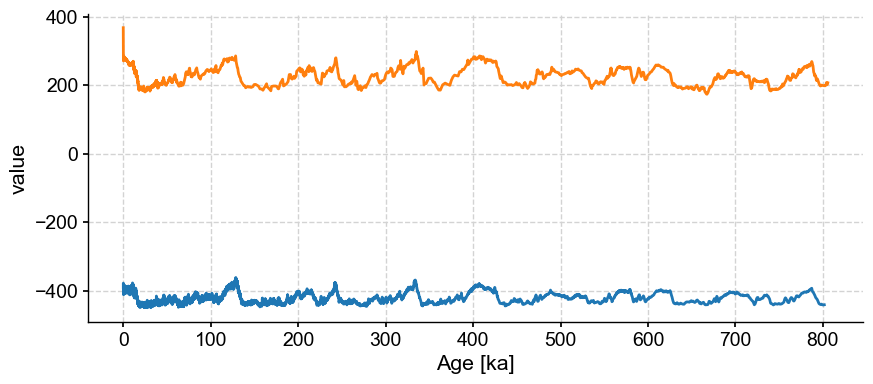

In [13]:
ms = pyleo.MultipleSeries([dDts,co2ts])
ms.plot()

By default, the MultipleSeries class assumes commensurate units, which is not really the case here. Fear not, we can just standardize the series:

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

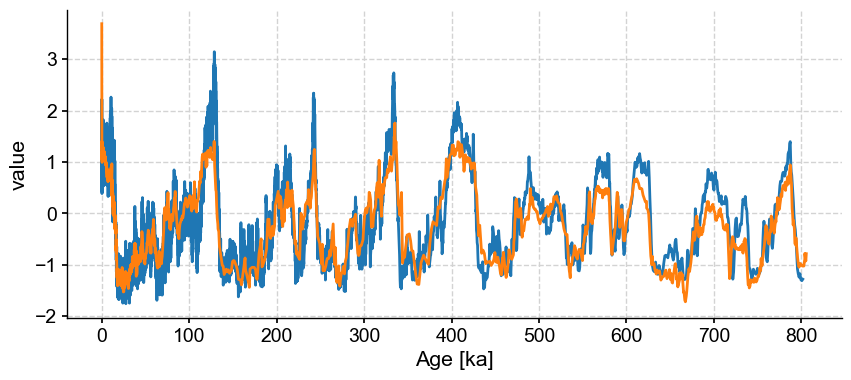

In [14]:
ms.standardize().plot()

We seek to understand potential lead/lag relationships between those two series. Before that, a brief primer: the temperature proxy $\delta D$ is measured on the ice, whereas $CO_2$ is measured in the air trapped in the ice. Because bubbles close only progressively as the firn gets compacted, the air can be younger than the surrouding ice by several hundred years. The ice core community has worked diligently on this for decades and have made very clever adjustments to correct for this effect, but that is to be kept in mind when comparing those two data streams. 

With that in mind, let us apply [wavelet transform coherency](https://hal.archives-ouvertes.fr/hal-00302394/) to identify phase relationships between the two series at various scales:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


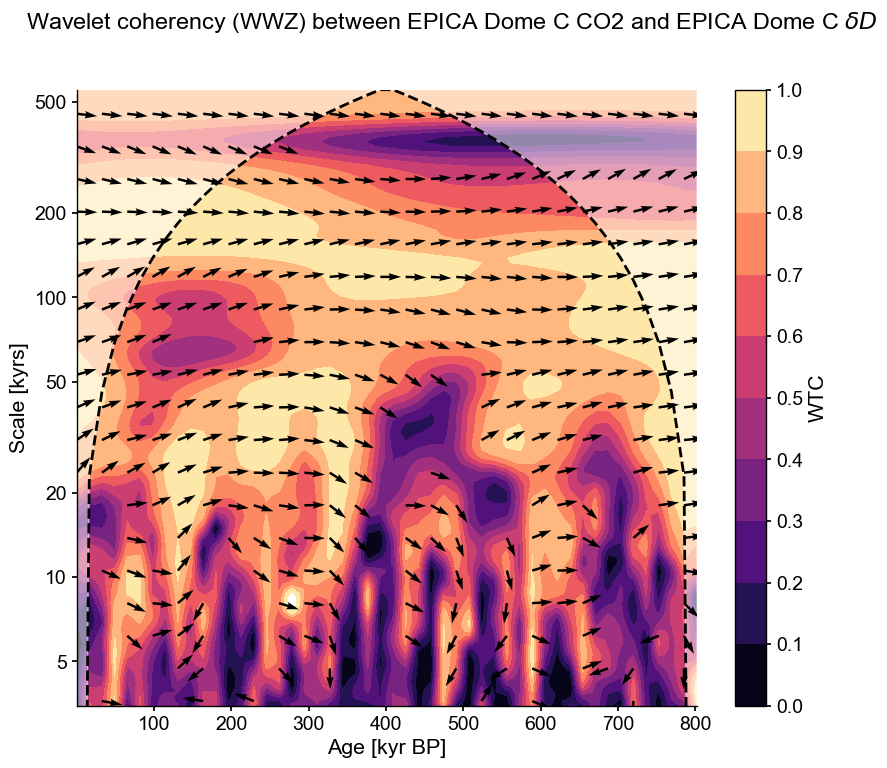

In [15]:
coh = co2ts.wavelet_coherence(dDts,method='wwz')
fig, ax = coh.plot()

This plot shows two things
- the wavelet transform coherency (WTC), which may be thought of as a (squared) correlation coefficient in time-scale space: 0 if the series do not covary, 1 if they vary in perfect unison at that time and scale. 
- the phase angle between the two series, using a trigonometric convention (right = 0, top = 90 degrees, left = 180 degrees, bottom = -90 or + 270 degrees).

Arrows pointing to the right indicate a phase angle close to zero at all scales longer than precession. We can quantify that by computing the average phase angle in a given range of scales, like so:

In [16]:
coh.phase_stats(scales=[80,100])

Results(mean_angle=0.11337289763284727, kappa=22.001092896028084, sigma=0.21570904255129503, kappa_hi=374.1389589948786, sigma_lo=0.051733788786691236)

This means that on orbital timescales, the two series are essentially in phase ; there is no _consistent_ lead or lag between the two series. This is remarkable given the dating challenges mentioned earlier, and is widely interpreted to mean that on such timescales, atmospheric $CO_2$ is a part of a positive feedback loop amplifying orbitally-triggered changes in temperature. However, the variance of this angle is fairly high, and by this test it does not register as a very consistent signal.
Lastly, note that in the anthropogenic era, atmospheric $CO_2$ is of course a forcing (the largest climate forcing, currently), acting on much, much faster timescales for which the climate system is still catching up. You would not know it from this analysis, but it's important to state out loud, given that climate deniers have an annoying tendency to cherry-pick the paleoclimate record in support of their feeble arguments. 

One might be tempted to interpret phase angles at shorter scales. Let us first see if they are significant against AR(1) benchmarks. As before this can be done in one function call, though some patience is required to obtain the result. 

In [17]:
coh_sig = coh.signif_test(number=100)

Performing wavelet coherence on surrogate pairs: 100%|██████████| 100/100 [26:04<00:00, 15.64s/it]


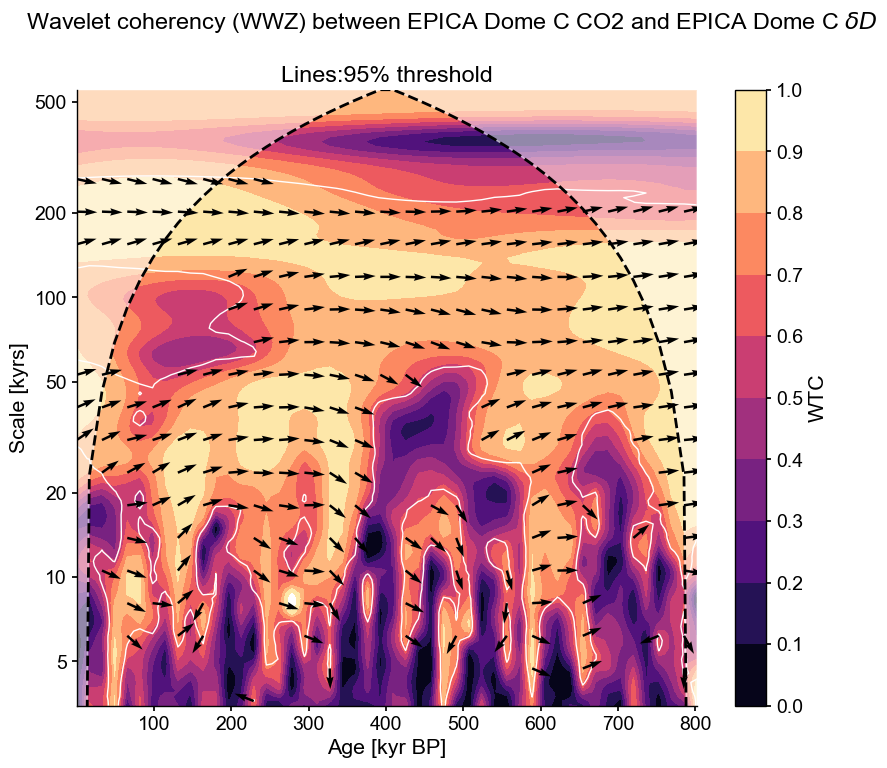

In [18]:
fig, ax = coh_sig.plot()

These phase differences are indeed significant according to this test, but mostly inconsistent (at a given scale, the arrows veer one way or the other). This would not be a good candidate for identifying a robust lead or lag. One would find the same result with `phase_stats()`. 

Another consideration is that coherency is like the correlation coefficient in wavelet space: it tells you how similar two series are for a given time and scale, yet it says nothing about what fraction of the total variability is shared. This is better measured by the cross-wavelet transform (XWT), which highlights areas of high common power. Both of those, along with the original series, can be visualized with one swift function call:

(<Figure size 900x1200 with 6 Axes>,
 {'ts1': <Axes: ylabel='$CO_2$ [ppm]'>,
  'ts2': <Axes: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>,
  'wtc': <Axes: ylabel='Scale [kyrs]'>,
  'xwt': <Axes: xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>})

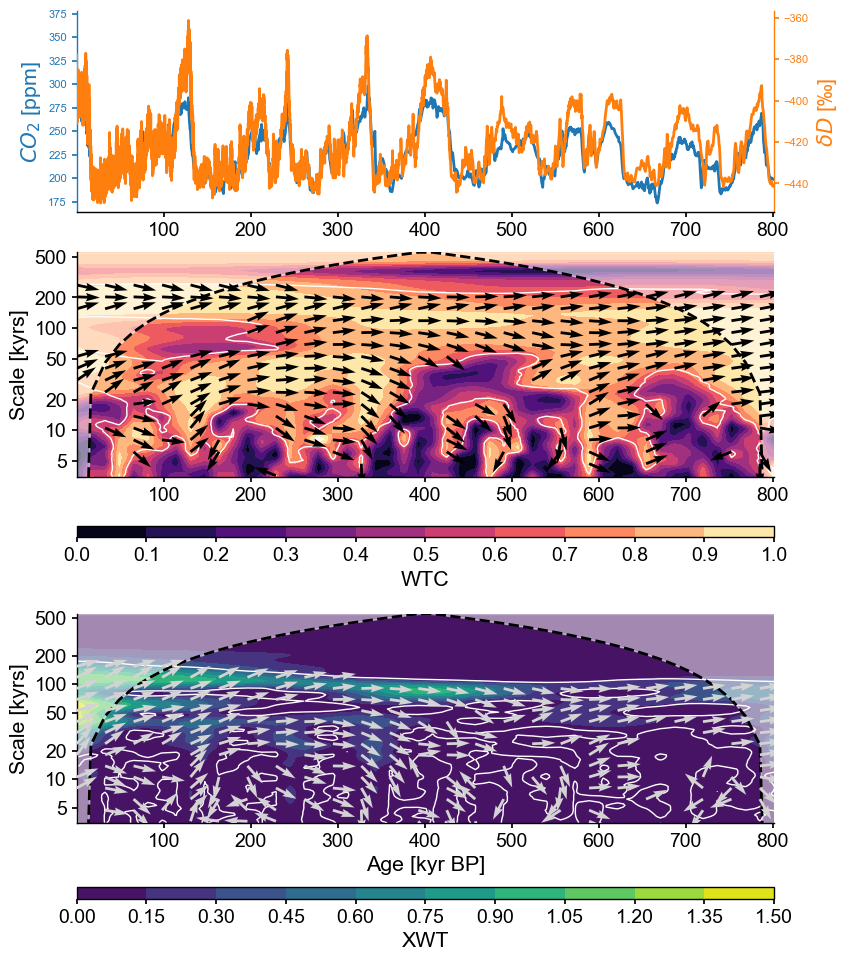

In [19]:
coh_sig.dashboard()

Here we see that the orbital bands are the only ones to show up consistently throughout the record, but precession and obliquity fade before 200 ky BP in their common power, and the XWT band near 120 ka drifts to 80ka back in time. This means that, out of the large swathes of WTC one would consider "coherent", only those areas highlighted in XWT in green-yellow are likely important.  That's where we stop the banter, though: when you are getting down to that level, you had better be a glaciologist or talk to one about what is going on in those datasets. 

### Takeways

- `Pyleoclim` enables wavelet and wavelet coherence analysis. 
- evenly-spaced data are handled with the CWT algorithm of [Torrence & Compo (1998)](https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2), which is very fast; unevenly-spaced data are handled through the WWZ algorithm of [Foster (1996)](https://adsabs.harvard.edu/full/1996AJ....112.1709F), which is slow. The temptation to interpolate is strong, but it has serious downsides (INTERPOLATION = MAKING UP DATA!). WWZ should be preferred, though CWT+interpolation can be used at exploratory stages. 
- Both [Scalogram](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#scalogram-pyleoclim-scalogram) and [Coherence](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#coherence-pyleoclim-coherence) objects have a built-in `signif_test()` method, which the `plot()` method will know what to do with. 
- Wavelet Transform Coherency may be thought of as a (squared) correlation coefficient in time-scale space: 0 if the series do not covary, 1 if they vary in perfect unison at that time and scale. 
- Properly interpreting the results of wavelet and wavelet coherence analyses requires knowing something about the methods. 

In [2]:
%watermark -n -u -v -iv -w

Last updated: Mon Jun 17 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

numpy     : 1.26.4
matplotlib: 3.9.0
pyleoclim : 1.0.0
pandas    : 2.1.4

Watermark: 2.4.3

